# Banzhaf Semi-values for data valuation

This notebook showcases [Data Banzhaf: A Robust Data Valuation Framework for Machine Learning](https://proceedings.mlr.press/v206/wang23e.html) by Wang, and Jia.

Computing Banzhaf semi-values using pyDVL follows basically the same procedure as all other semi-value-based methods like Shapley values. However, Data-Banzhaf tends to be more robust to stochasticity in the training process than other semi-values. A property that we study here.

Additionally, we compare two sampling techniques: the standard permutation-based Monte Carlo sampling, and the so-called MSR (Maximum Sample Reuse) principle.

In order to highlight the strengths of Data-Banzhaf, we require a stochastic model. For this reason, we use a CNN to classify handwritten digits from the [scikit-learn toy datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset).

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import numpy as np
import matplotlib.pyplot as plt

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

is_CI = os.environ.get("CI")
random_state = 24
n_jobs = 16
random.seed(random_state)

We will be using the following functions from pyDVL. The main entry point is the function `compute_banzhaf_semivalues()`.
In order to use it we need the classes [Dataset](../../api/pydvl/utils/dataset/#pydvl.utils.dataset.Dataset), [Utility](../../api/pydvl/utils/utility/#pydvl.utils.utility.Utility) and [Scorer](../../api/pydvl/utils/score/#pydvl.utils.score.Scorer).

In [3]:
%autoreload
from pydvl.reporting.plots import plot_shapley
from support.banzhaf import load_digits_dataset
from pydvl.value import *

/home/miguel/devel/tfl/pydvl/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(


## Loading the dataset

We use a support function, `load_digits_dataset()`, which downloads the data and prepares it for usage. It returns four arrays that we then use to construct a [Dataset](../../api/pydvl/utils/dataset/#pydvl.utils.dataset.Dataset). The data consists of grayscale images of shape 8x8 pixels with 16 shades of gray. These images contain handwritten digits from 0 to 9.

In [4]:
training_data, _, test_data = load_digits_dataset(
    test_size=0.3, random_state=random_state
)

RuntimeError: PyTorch is required in order to load the Digits Dataset

In [5]:
# In CI we only use a subset of the training set
training_data = list(training_data)
if is_CI:
    training_data[0] = training_data[0][:10]
    training_data[1] = training_data[1][:10]
    max_checks = 1
else:
    training_data[0] = training_data[0][:200]
    training_data[1] = training_data[1][:200]
    max_checks = 1000

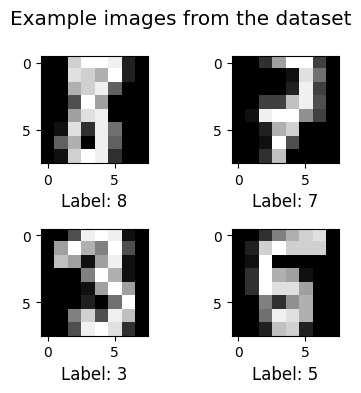

In [6]:
# Visualize some of the data
fig, axes = plt.subplots(2, 2, figsize=(4, 4))
for i in range(4):
    ax = axes[i % 2, i // 2]
    ax.imshow(np.reshape(training_data[0][i], (8, 8)), cmap="gray")
    ax.set_xlabel(f"Label: {training_data[1][i]}")
plt.suptitle("Example images from the dataset")
plt.tight_layout()
plt.show()

Training and test data are then used to instantiate a [Dataset](../../api/pydvl/utils/dataset/#pydvl.utils.dataset.Dataset) object:

In [7]:
dataset = Dataset(*training_data, *test_data)

## Creating the utility and computing Banzhaf semivalues

Now we can calculate the contribution of each training sample to the model performance. First we need a model and a [Scorer](../../api/pydvl/utils/score/#pydvl.utils.score.Scorer).

As a model, we use a simple CNN written torch, and wrapped into an object to convert numpy arrays into tensors (as of v0.9.0 valuation methods in pyDVL work only with numpy arrays). Note that any model that implements the protocol [pydvl.utils.types.SupervisedModel](../../api/pydvl/utils/types/#pydvl.utils.types.SupervisedModel), which is just the standard sklearn interface of `fit()`,`predict()` and `score()` can be used to construct the utility.

In [8]:
import torch
from support.banzhaf import TorchCNNModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TorchCNNModel(lr=0.001, epochs=40, batch_size=32, device=device)
model.fit(x=training_data[0], y=training_data[1])

print(f"Train Accuracy: {model.score(x=training_data[0], y=training_data[1]):.3f}")
print(f"Test Accuracy: {model.score(x=test_data[0], y=test_data[1]):.3f}")

Train Accuracy: 0.665
Test Accuracy: 0.619


The final component is the scoring function. It can be anything like accuracy or $R^2$, and is set with a string from the [standard sklearn scoring methods](https://scikit-learn.org/stable/modules/model_evaluation.html). Please refer to that documentation on information on how to define your own scoring function.

We group dataset, model and scoring function into an instance of [Utility](../../api/pydvl/utils/utility/#pydvl.utils.utility.Utility) and compute the Banzhaf semi-values. We take all defaults, and choose to stop computation using the [MaxChecks](../../api/pydvl/value/stopping/#pydvl.value.stopping.MaxChecks) stopping criterion, which terminates after a fixed number of calls to it. With the default `batch_size` of 1 this means that we will retrain the model.

Note how we enable caching using memcached (assuming memcached runs with the default configuration for localhost). This is necessary in the current preliminary implementation of [permutation sampling](../../api/pydvl/value/sampler/#pydvl.value.sampler.PermutationSampler), which is the default for [compute_banzhaf_semivalues](../../api/pydvl/value/semivalues#pydvl.value.semivalues.compute_banzhaf_semivalues).

In [9]:
from pydvl.utils import MemcachedCacheBackend, MemcachedClientConfig

# Compute regular Banzhaf semivalue
utility = Utility(
    model=TorchCNNModel(),
    data=dataset,
    scorer=Scorer("accuracy", default=0.0, range=(0, 1)),
    cache_backend=MemcachedCacheBackend(MemcachedClientConfig())
)
values = compute_banzhaf_semivalues(
    utility, done=MaxChecks(max_checks), n_jobs=n_jobs, progress=True
)
values.sort(key="value")
df = values.to_dataframe(column="banzhaf_value", use_names=True)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
  0%|          | 0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/backends/joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
100%|█████████▉| 99.9/100 [01:39<00:00,  1.01%/s]              


The returned dataframe contains the mean and variance of the Monte Carlo estimates for the values:

In [10]:
df.head()

,data_value,data_value_stderr
66,-1.048524,0.029862
152,-0.994573,0.008960
64,-0.760825,0.018543
3,-0.718165,0.642347
14,-0.707569,0.323538


Let us plot the results. In the next cell we will take the 30 images with the lowest score and plot their values with 95% Normal confidence intervals. Keep in mind that Permutation Monte Carlo Banzhaf is typically very noisy, and it can take many steps to arrive at a clean estimate.

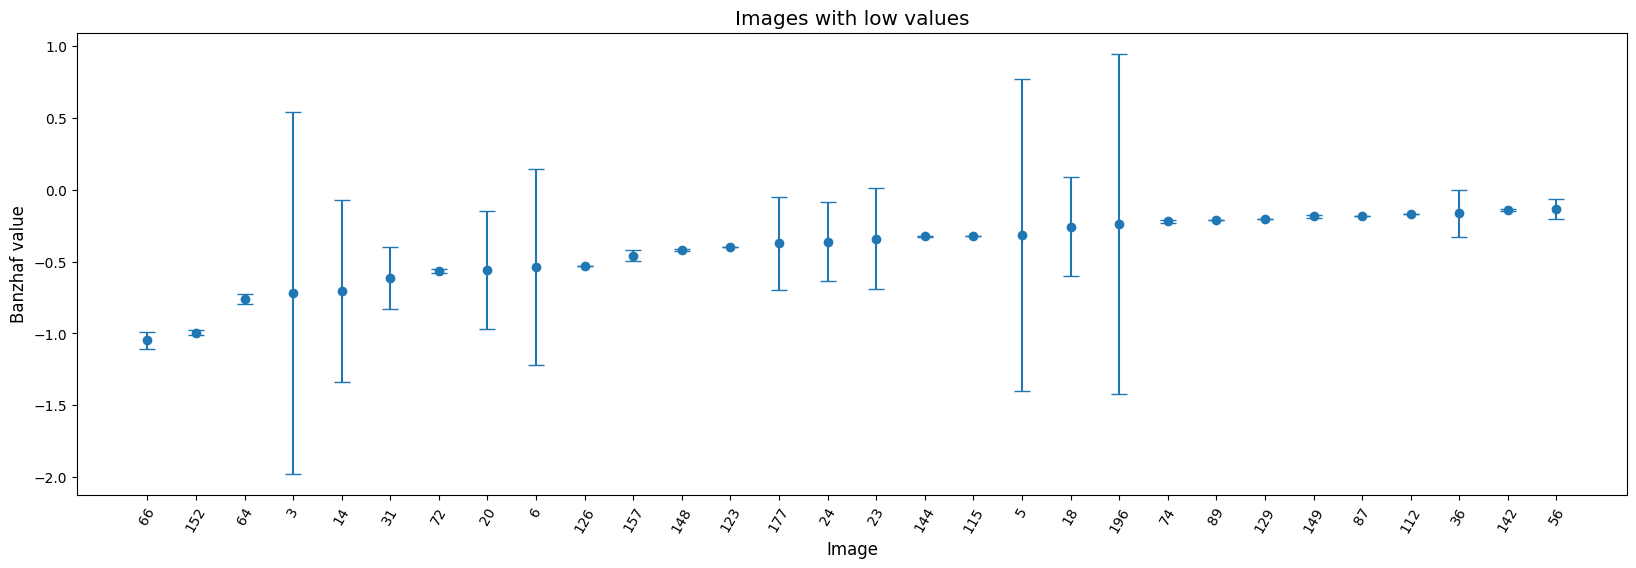

In [11]:
low_dvl = df.iloc[:30].copy()
low_dvl.index = low_dvl.index.map(str)
plot_shapley(
    low_dvl,
    level=0.05,
    title="Images with low values",
    xlabel="Image",
    ylabel="Banzhaf value",
)
plt.show()

## Evaluation on anomalous data

An interesting use-case for data valuation is finding anomalous data. Maybe some of the data is really noisy or has been mislabeled. To simulate this, we will change some of the labels of our dataset and add noise to some others. Intuitively, these anomalous data points should then have a lower value.

To evaluate this, let us first check the average value of the first 10 data points, as these will be the ones that we modify. Currently, these are the 10 data points with the highest values:

In [12]:
high_dvl = df.iloc[-10:].copy()
print(f"Average value of first 10 data points: {high_dvl['banzhaf_value'].mean()}")
print(f"Exact values:\n{high_dvl['banzhaf_value']}")

Average value of first 10 data points: 0.6300257540520159
Exact values:
39     0.392304
167    0.461181
33     0.468827
169    0.519828
135    0.551593
19     0.594768
51     0.636773
140    0.741426
71     0.880786
121    1.052771
Name: data_value, dtype: float64


For the first 5 images, we will falsify their label, for images 6-10, we will add some noise.

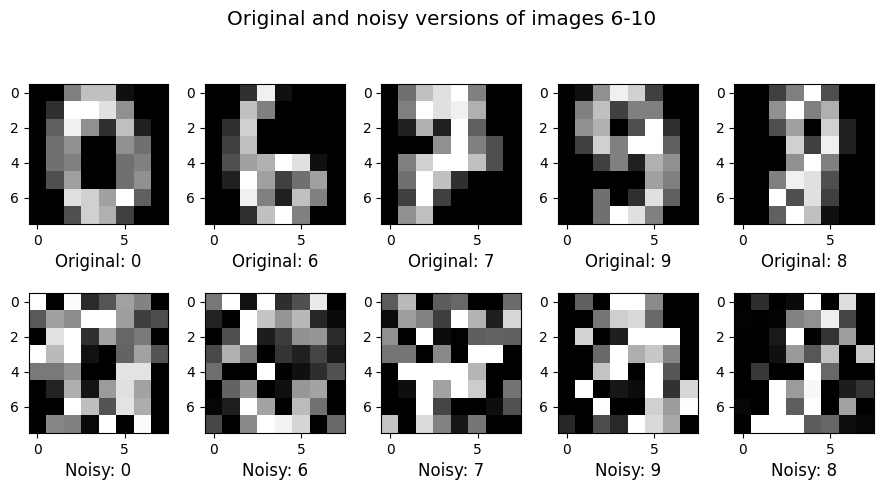

In [13]:
x_train_anomalous = training_data[0].copy()
y_train_anomalous = training_data[1].copy()
anomalous_indices = high_dvl.index.map(int).values[:10]

# Set label of first 5 images to 0
y_train_anomalous[high_dvl.index.map(int).values[:5]] = 0

# Add noise to images 6-10
indices = high_dvl.index.values[5:10].astype(int)
current_images = x_train_anomalous[indices]
noisy_images = current_images + 0.5 * np.random.randn(*current_images.shape)
noisy_images[noisy_images < 0] = 0.0
noisy_images[noisy_images > 1] = 1.0
x_train_anomalous[indices] = noisy_images

fig, axes = plt.subplots(2, 5, figsize=(9, 5))
for i in range(5):
    axes[0, i].imshow(np.reshape(current_images[i], (8, 8)), cmap="gray")
    axes[1, i].imshow(np.reshape(noisy_images[i], (8, 8)), cmap="gray")
    axes[0, i].set_xlabel(f"Original: {training_data[1][indices[i]]}")
    axes[1, i].set_xlabel(f"Noisy: {training_data[1][indices[i]]}")
plt.suptitle("Original and noisy versions of images 6-10")
plt.tight_layout()
plt.show()

In [14]:
anomalous_dataset = Dataset(
    x_train=x_train_anomalous,
    y_train=y_train_anomalous,
    x_test=test_data[0],
    y_test=test_data[1],
)

anomalous_utility = Utility(
    model=TorchCNNModel(),
    data=anomalous_dataset,
    scorer=Scorer("accuracy", default=0.0, range=(0, 1)),
    cache_backend=MemcachedCacheBackend(MemcachedClientConfig())
)
anomalous_values = compute_banzhaf_semivalues(
    anomalous_utility, done=MaxChecks(max_checks), n_jobs=n_jobs, progress=True
)
anomalous_values.sort(key="value")
anomalous_df = anomalous_values.to_dataframe(column="banzhaf_value", use_names=True)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
  0%|          | 0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/backends/joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
100%|█████████▉| 99.9/100 [01:39<00:00,  1.01%/s]              


Let us now take a look at the low-value images and check how many of our anomalous images are part of it.

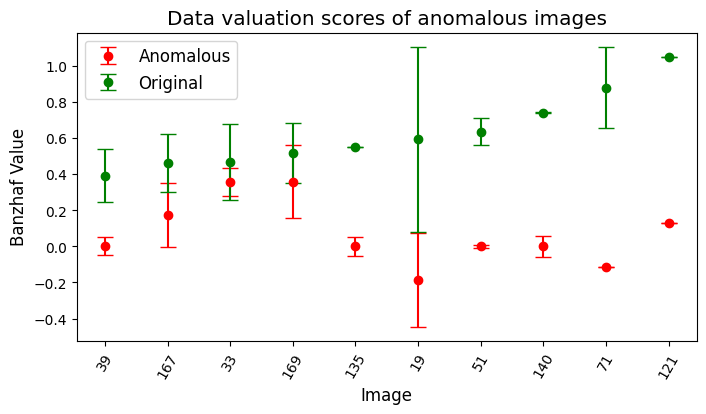

In [15]:
from scipy.stats import norm


plot_data = anomalous_df.loc[anomalous_indices].copy()
plot_data["original_banzhaf_value"] = df.loc[anomalous_indices]["banzhaf_value"]
plot_data["original_banzhaf_value_stderr"] = df.loc[anomalous_indices]["banzhaf_value_stderr"]
plot_data.index = plot_data.index.map(str)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
yerr = norm.ppf(1 - 0.05 / 2) * plot_data["banzhaf_value_stderr"]
original_yerr = norm.ppf(1 - 0.05 / 2) * plot_data["original_banzhaf_value_stderr"]
ax.errorbar(
    x=plot_data.index,
    y=plot_data["banzhaf_value"],
    yerr=yerr,
    fmt="o",
    capsize=6,
    color="red",
    label="Anomalous",
)
ax.errorbar(
    x=plot_data.index,
    y=plot_data["original_banzhaf_value"],
    yerr=original_yerr,
    fmt="o",
    capsize=6,
    color="green",
    label="Original",
)
ax.set_xlabel("Image")
ax.set_ylabel("Banzhaf Value")
ax.set_title("Data valuation scores of anomalous images")
plt.legend()
plt.xticks(rotation=60)
plt.show()

As can be seen in this figure, the valuation of the data points has decreased significantly by adding noise or falsifying their labels. This shows the potential of using Banzhaf values or other data valuation methods to detect mislabeled data points or noisy input data.

In [16]:
print(
    f"Average value of original data points: {plot_data['original_banzhaf_value'].mean()}"
)
print(
    f"Average value of modified, anomalous data points: {plot_data['banzhaf_value'].mean()}"
)
print(
    "For reference, these are the average data values of all data points used for training (anomalous):"
)
print(anomalous_df.mean())
print("These are the average data values of all points (original data):")
print(df.mean())

Average value of original data points: 0.6300257540520159
Average value of modified, anomalous data points: 0.07210118735126189
For reference, these are the average data values of all data points used for training (anomalous):
data_value           0.022450
data_value_stderr    0.083306
dtype: float64
These are the average data values of all points (original data):
data_value          -0.016296
data_value_stderr    0.118257
dtype: float64


### Maximum Sample Reuse Banzhaf

Despite the previous results already being useful, we had to retrain the model a number of times and yet the variance of the value estimates was high. This has consequences for the stability of the top-k ranking of points, which decreases the applicability of the method. We now introduce a different sampling method called Maximum Sample Reuse (MSR) which reuses every sample for updating the Banzhaf values. The method was introduced by the authors of Data-Banzhaf and is much more sample-efficient, as we will show.

We next construct a new utility. Note how this time we don't use a cache: the chance of hitting twice the same subset of the training set is low enough that one can dispense with it (nevertheless it can still be useful, e.g. when running many experiments).

In [ ]:
utility = Utility(
    model=TorchCNNModel(),
    data=dataset,
    scorer=Scorer("accuracy", default=0.0, range=(0, 1)),
    #cache_backend=MemcachedCacheBackend(MemcachedClientConfig())
)

Computing the values is the same, but we now use a better stopping criterion. Instead of fixing the number of utility evaluations with [MaxChecks](../../api/pydvl/value/stopping/#pydvl.value.stopping.MaxChecks), we use [RankStability](../../api/pydvl/value/stopping/#pydvl.value.stopping.RankStability) to stop when the change in Spearman correlation between the ranking of two successive iterations is below a threshold. 

In [17]:
values = compute_msr_banzhaf_semivalues(
    utility,
    done=RankStability(0.0001),
    n_jobs=n_jobs,
    progress=True,
)
values.sort(key="value")
msr_df = values.to_dataframe(column="banzhaf_value", use_names=True)

  0%|          | 0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/backends/joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
  0%|          | 0.0/100 [00:03<?, ?%/s]/home/jakob/Documents/pyDVL/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|█████████▉| 99.7319432985825/100 [00:09<00:00, 10.28%/s]  


Inspection of the values reveals (generally) much lower variances. Notice the number of updates to each value as well.

In [18]:
msr_df.head()

,data_value,data_value_stderr
136,-0.095575,0.049190
142,-0.087262,0.043481
187,-0.085364,0.046185
22,-0.081251,0.039468
5,-0.080346,0.041551


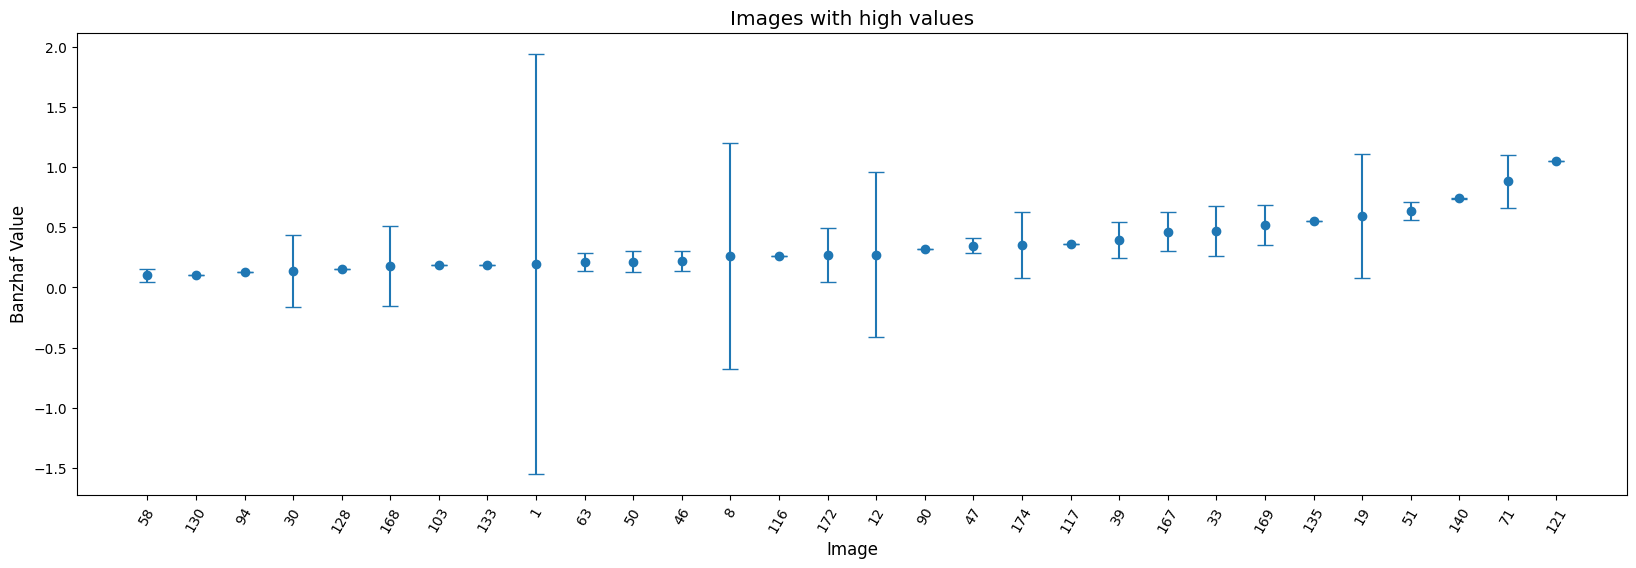

In [19]:
high_dvl = df.iloc[-30:]
high_dvl.index = high_dvl.index.map(str)
ax = plot_shapley(
    high_dvl,
    title="Images with high values",
    xlabel="Image",
    ylabel="Banzhaf Value",
)
plt.show()

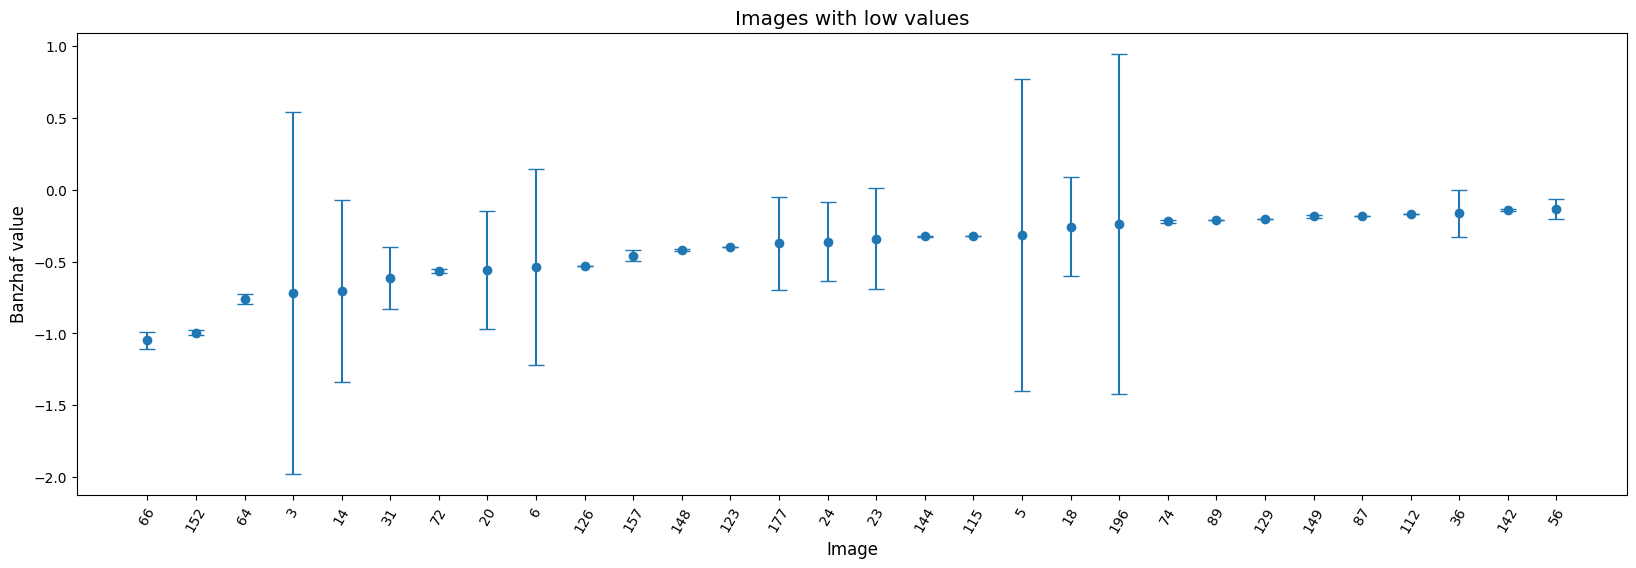

In [20]:
low_dvl = df.iloc[:30]
low_dvl.index = low_dvl.index.map(str)
ax = plot_shapley(
    low_dvl,
    title="Images with low values",
    xlabel="Image",
    ylabel="Banzhaf value",
)
plt.show()

### Compare convergence speed of Banzhaf and MSR Banzhaf Values

Conventional margin-based samplers produce require evaluating the utility twice to do one update of the value, and permutation samplers do instead $n+1$ evaluations for $n$ updates. Maximum Sample Reuse (MSR) updates instead all indices in every sample that the utility evaluates. We compare the convergence rates of these methods.

In order to do so, we will compute the semi-values using different samplers and use a high number of iterations to make sure that the values have converged.

In [21]:
if is_CI:
    max_checks = 1
    moving_avg = 1
else:
    max_checks = 10000
    moving_avg = 200

In [22]:
from sklearn.linear_model import SGDClassifier

if is_CI:
    utility = Utility(
        model=SGDClassifier(max_iter=2),
        data=dataset,
        scorer=Scorer("accuracy", default=0.0, range=(0, 1)),
    )
else:
    utility = Utility(
        model=TorchCNNModel(),
        data=dataset,
        scorer=Scorer("accuracy", default=0.0, range=(0, 1)),
    )

In [23]:
def get_semivalues_and_history(
    sampler_t, max_checks=max_checks, n_jobs=n_jobs, progress=True
):
    _history = HistoryDeviation(n_steps=max_checks, rtol=1e-9)
    if sampler_t == MSRSampler:
        _values = compute_msr_banzhaf_semivalues(
            utility,
            sampler_t=sampler_t,
            done=MaxChecks(max_checks + 2) | _history,
            n_jobs=n_jobs,
            progress=progress,
        )
    else:
        _values = compute_banzhaf_semivalues(
            utility,
            done=MaxChecks(max_checks + 2) | _history,
            n_jobs=n_jobs,
            progress=progress,
        )
    return _history, _values

In [24]:
# Monte Carlo Permutation Sampling Banzhaf semivalues
history_permutation, permutation_values = get_semivalues_and_history(PermutationSampler)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
  0%|          | 0/100 [00:00<?, ?%/s]/home/jakob/Documents/pyDVL/src/pydvl/parallel/backends/joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
100%|█████████▉| 99.99000199960008/100 [18:04<00:00, 10.84s/%]       


In [25]:
# MSR Banzhaf values
history_msr, msr_values = get_semivalues_and_history(MSRSampler)

100%|█████████▉| 99.98000399920016/100 [09:38<00:00,  5.79s/%]       /home/jakob/Documents/pyDVL/venv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
100%|█████████▉| 99.99000199960008/100 [09:41<00:00,  5.81s/%]


In [26]:
# UniformSampler
history_uniform, uniform_values = get_semivalues_and_history(UniformSampler)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
100%|█████████▉| 99.99000199960008/100 [16:58<00:00, 10.18s/%]       


In [27]:
# AntitheticSampler
history_antithetic, antithetic_values = get_semivalues_and_history(AntitheticSampler)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
100%|█████████▉| 99.99000199960008/100 [15:48<00:00,  9.48s/%]       


In [28]:
# RandomHierarchicalSampler
history_random, random_values = get_semivalues_and_history(RandomHierarchicalSampler)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
100%|█████████▉| 99.99000199960008/100 [15:38<00:00,  9.38s/%]       


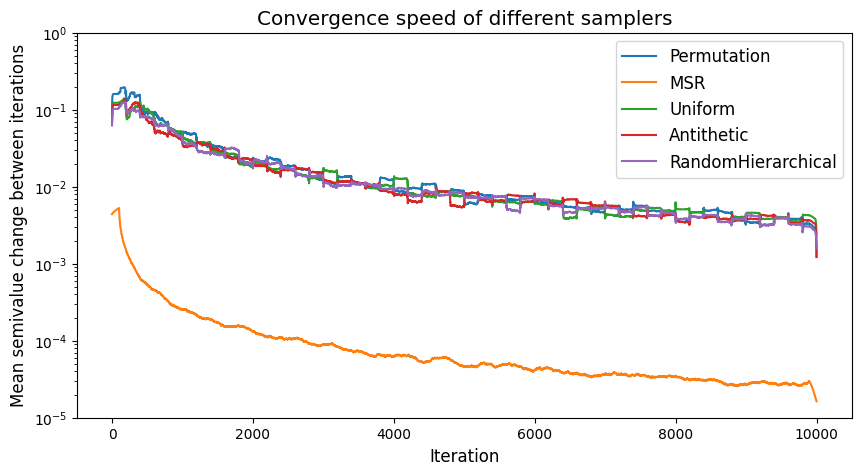

In [29]:
# Compare convergence speed of both methods
names = ["Permutation", "MSR", "Uniform", "Antithetic", "RandomHierarchical"]
all_values = [
    history_permutation._memory,
    history_msr._memory,
    history_uniform._memory,
    history_antithetic._memory,
    history_random._memory,
]
distances = [[] for _ in names]
moving_avgs = []

for sampler_id, name in enumerate(names):
    for iteration in range(max_checks):
        abs_dist = np.abs(
            all_values[sampler_id][:, iteration]
            - all_values[sampler_id][:, iteration + 1]
        )
        if abs_dist.max() == 0.0:
            distances[sampler_id].append(0.0)
        else:
            distances[sampler_id].append(np.mean(abs_dist[abs_dist > 0]))
    moving_avgs.append(
        np.convolve(
            distances[sampler_id], np.ones(moving_avg) / moving_avg, mode="same"
        )
    )

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for sampler_id, name in enumerate(names):
    ax.plot(list(range(max_checks)), moving_avgs[sampler_id], label=name)
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean semivalue change between iterations")
ax.set_title("Convergence speed of different samplers")
plt.yscale("log")
plt.ylim(1e-5, 1)
plt.legend()
plt.show()

The plot above visualizes the convergence speed of different samplers used for Banzhaf semivalue calculation. /It shows the average magnitude of how much the semivalues are updated in every step of the algorithm. 

As you can see, **MSR Banzhaf** stabilizes much faster. After 1000 iterations (subsets sampled and evaluated with the utility), Permutation Monte Carlo Banzhaf has evaluated the marginal function about 5 times per data point (we are using 200 data points). For MSR, the semivalue of each data point was updated 1000 times. Due to this, the values converge much faster wrt. the number of utility evaluations, which is the key advantage of MSR sampling. 

MSR sampling does come at a cost, however, which is that the updates to the semivalues are more noisy than in other methods.  We will analyze the impact of this tradeoff in the next sections. First, let us look at how similar all the computed semivalues are. They are all Banzhaf values, so in a perfect world, all samplers should result in the exact same semivalues. However, due to randomness in the utility (recall that we use a neural network) and randomness in the samplers, the resulting values are likely never exactly the same. Another quality measure is that a good sampler would lead to very consistent values, a bad one to less consistent values. Let us first examine how similar the results are, then we'll look at consistency.

### Similarity of the semivalues computed using different samplers

In [30]:
names = ["Permutation", "MSR", "Uniform", "Antithetic", "RandomHierarchical"]
values = [
    permutation_values,
    msr_values,
    uniform_values,
    antithetic_values,
    random_values,
]
top_consistency = np.zeros((len(names), len(names)))
low_consistency = np.zeros((len(names), len(names)))
twenty_percent = training_data[0].shape[0] // 5

for sampler1_id, sampler1_values in enumerate(values):
    for sampler2_id, sampler2_values in enumerate(values):
        sampler1_values.sort(key="value")
        sampler2_values.sort(key="value")
        top_20_1 = set(sampler1_values.indices[-twenty_percent:].tolist())
        lower_20_1 = set(sampler1_values.indices[:twenty_percent].tolist())
        top_20_2 = set(sampler2_values.indices[-twenty_percent:].tolist())
        lower_20_2 = set(sampler2_values.indices[:twenty_percent].tolist())
        top_consistency[sampler1_id, sampler2_id] = len(top_20_1.intersection(top_20_2))
        low_consistency[sampler1_id, sampler2_id] = len(
            lower_20_1.intersection(lower_20_2)
        )

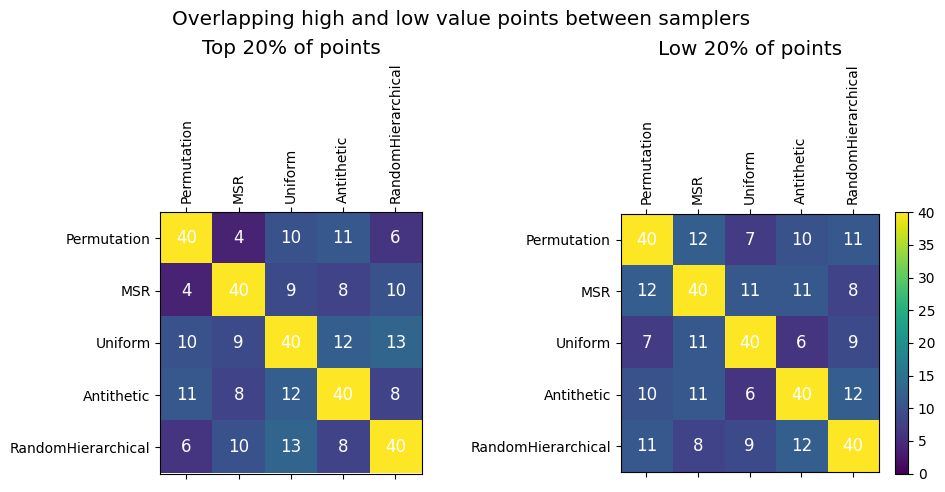

In [31]:
fix, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].matshow(top_consistency, vmin=0, vmax=twenty_percent)
mat2 = axes[1].matshow(low_consistency, vmin=0, vmax=twenty_percent)
axes[0].set_xticks(np.arange(len(names)), names, rotation=90)
axes[1].set_xticks(np.arange(len(names)), names, rotation=90)
for (i, j), z in np.ndenumerate(top_consistency):
    axes[0].text(j, i, f"{int(z)}", ha="center", va="center", c="white")
for (i, j), z in np.ndenumerate(low_consistency):
    axes[1].text(j, i, f"{int(z)}", ha="center", va="center", c="white")

axes[0].set_yticks(np.arange(len(names)), names)
axes[1].set_yticks(np.arange(len(names)), names)
axes[0].set_title("Top 20% of points")
axes[1].set_title("Low 20% of points")
fig.colorbar(mat2)
plt.suptitle("Overlapping high and low value points between samplers")
plt.tight_layout()
plt.show()

This plot shows that the samplers lead to quite different Banzhaf semivalues, however, all of them have some points in common.  
The MSR Sampler does not seem to be significantly worse than any others. 

In an ideal setting without randomness, the overlap of points would be higher, however, the stochastic nature of the CNN model that we use together with the
fact that we use only 200 data points for training, might overshadow these results.  

In [36]:
all_in_common = set(permutation_values.indices.tolist())
for sampler_id, sampler_values in enumerate(values):
    sampler_values.sort(key="value")
    top_20 = set(sampler_values.indices[-twenty_percent:].tolist())
    all_in_common = all_in_common.intersection(top_20)
print(
    f"Total number of top 20 points that all samplers have in common: {len(all_in_common)}"
)

Total number of top 20 points that all samplers have in common: 1


### Consistency of the semivalues

In this part, we want to analyze how consistent the semivalues returned by the different samplers are.  
To evaluate this, we will compute semivalues multiple times and check how many of the data points in the top and lowest 20% of valuation of the data overlap.

In [32]:
max_checks = [1000, 2000, 3000] if not is_CI else [1]
num_retries = 3 if not is_CI else 1
num_samplers = 5
twenty_percent = training_data[0].shape[0] // 5

In [33]:
# Run all experiments
from tqdm import tqdm


results = [[[] for i in range(num_samplers)] for _ in max_checks]
pbar = tqdm(total=len(max_checks) * num_retries * 5)
for sampler_index, sampler in enumerate(
    [
        PermutationSampler,
        MSRSampler,
        UniformSampler,
        AntitheticSampler,
        RandomHierarchicalSampler,
    ]
):
    for check_index, max_check in enumerate(max_checks):
        for retry in range(num_retries):
            _, vals = get_semivalues_and_history(
                sampler, max_checks=max_check, progress=False
            )
            results[check_index][sampler_index].append(vals)
            pbar.n = (
                sampler_index * (len(max_checks) * num_retries)
                + check_index * num_retries
                + retry
                + 1
            )
            pbar.refresh()

  0%|          | 0/45 [00:00<?, ?it/s]PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
/home/jakob/Documents/pyDVL/src/pydvl/parallel/backends/joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
 20%|██        | 9/45 [27:26<1:49:46, 182.96s/it]/home/jakob/Documents/pyDVL/venv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
100%|██████████| 45/45 [2:04:20<00:00, 165.80s/it]

In [34]:
# Extract results from experiments

plot_results_top = [[] for _ in range(num_samplers)]
plot_results_low = [[] for _ in range(num_samplers)]
for check_index, _ in enumerate(max_checks):
    for sampler_index, sampler in enumerate(
        [
            PermutationSampler,
            MSRSampler,
            UniformSampler,
            AntitheticSampler,
            RandomHierarchicalSampler,
        ]
    ):
        value_list = results[check_index][sampler_index]
        top_20 = None
        lower_20 = None
        for vals in value_list:
            vals.sort(key="value")
            if top_20 is None:
                top_20 = set(vals.indices[-twenty_percent:].tolist())
                lower_20 = set(vals.indices[:twenty_percent].tolist())
            else:
                top_20 = top_20.intersection(
                    set(vals.indices[-twenty_percent:].tolist())
                )
                lower_20 = lower_20.intersection(
                    set(vals.indices[:twenty_percent].tolist())
                )
        plot_results_top[sampler_index].append(len(top_20))
        plot_results_low[sampler_index].append(len(lower_20))

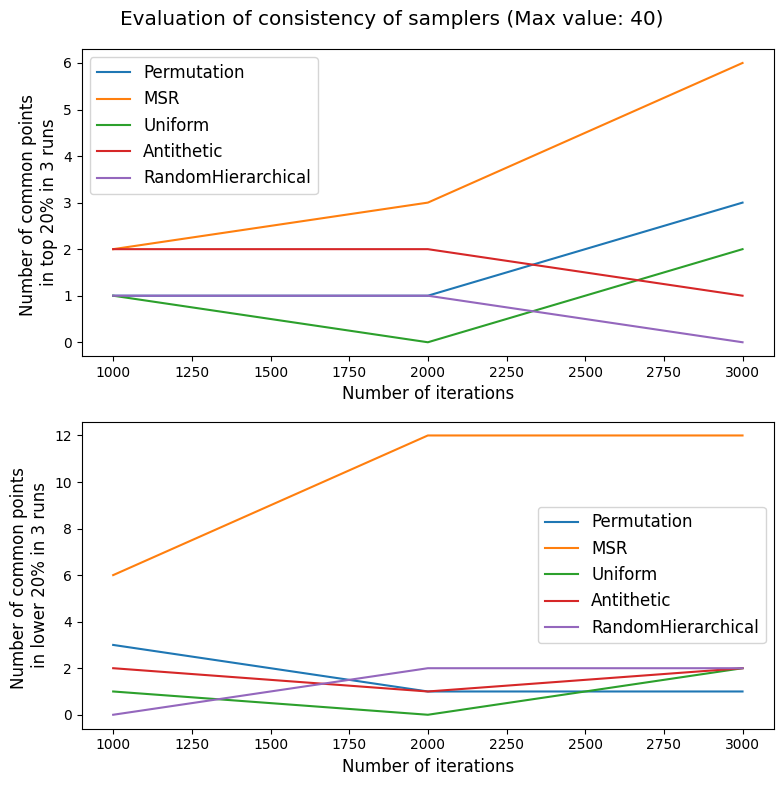

In [35]:
# Plot results

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
for sampler_index, name in enumerate(names):
    axes[0].plot(max_checks, plot_results_top[sampler_index], label=name)
    axes[1].plot(max_checks, plot_results_low[sampler_index], label=name)
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("Number of iterations")
axes[1].set_xlabel("Number of iterations")
axes[0].set_ylabel(f"Number of common points \nin top 20% in {num_retries} runs")
axes[1].set_ylabel(f"Number of common points \nin lower 20% in {num_retries} runs")
fig.suptitle(f"Evaluation of consistency of samplers (Max value: {twenty_percent})")
fig.tight_layout()
plt.show()

**Conclusion:**
MSR sampling updates the semivalue estimates a lot more frequently than any other sampler available, which leads to a lot **faster convergence**.  
Additionally, the sampler is more consistent with its value estimates than the other samplers, which might be caused by the higher number of value updates.  

In general, the recommendation is to try different samplers when computing semivalues and test, which one is best suited for your use case. The MSR sampler
seems like a more efficient sampler which may bring fast results and is well-suited for stochastic models.